# Time Series: Auto Regressive Methods

Auto Regressive is also a multiple regression in which the independent variables are time-lagged versions of the dependent variable.

AR (p)
p = number of lags

find p using PACF (find the number of lags which are not zero)

12 lags from PACF

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

# from statsmodels.tools.tsa import 

%matplotlib inline

### Load the Data

In [2]:
df = pd.read_csv('data/us_airline_carrier_passenger.csv')

df.head()

,month,passengers
0,2000-01-01,46492
1,2000-02-01,48526
2,2000-03-01,58764
3,2000-04-01,56033
4,2000-05-01,58201


### Preprocess the Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
month         240 non-null object
passengers    240 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


In [4]:
df['month'] = pd.to_datetime(df['month'])

df.dtypes

month         datetime64[ns]
passengers             int64
dtype: object

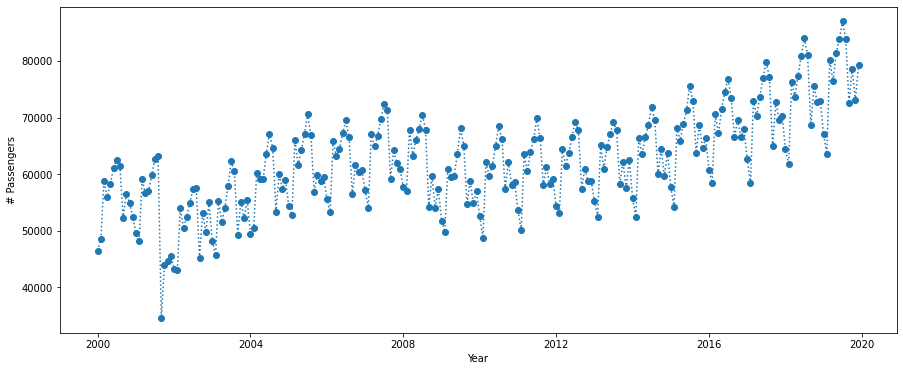

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df['month'], df['passengers'], 'o:')
plt.xlabel('Year')
plt.ylabel('# Passengers')
plt.show()

### Split Data into train and test

- train: upto 2016-Dec
- test: 2016-Dec to 2019-Dec

In [6]:
df.shape

(240, 2)

In [7]:
df_train = df[df['month'] <= datetime.datetime.strptime('2016-12-01', "%Y-%m-%d")]
df_test = df[df['month'] > datetime.datetime.strptime('2016-12-01', "%Y-%m-%d")]

In [8]:
df_train.tail()

,month,passengers
199,2016-08-01,73450
200,2016-09-01,66477
201,2016-10-01,69539
202,2016-11-01,66591
203,2016-12-01,67983


In [9]:
df_test.head()

,month,passengers
204,2017-01-01,62621
205,2017-02-01,58377
206,2017-03-01,72962
207,2017-04-01,70262
208,2017-05-01,73679


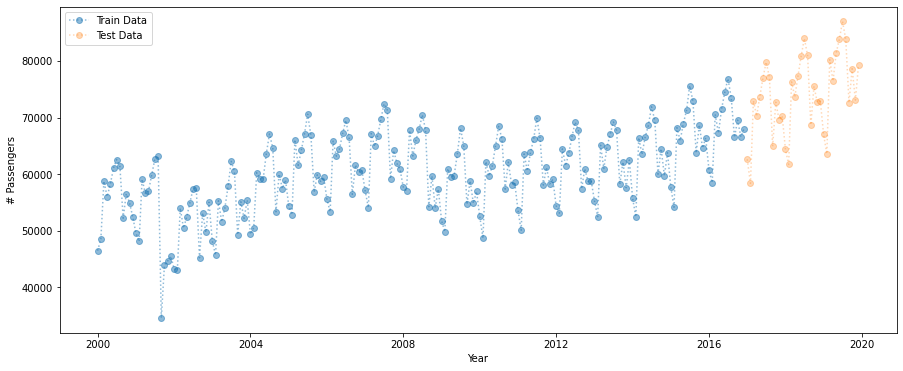

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['month'], df_train['passengers'], 'o:', alpha=0.5)
plt.plot(df_test['month'], df_test['passengers'], 'o:', alpha=0.3)
plt.legend(['Train Data', 'Test Data'])
plt.xlabel('Year')
plt.ylabel('# Passengers')
plt.show()

**ACF and PACF**

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

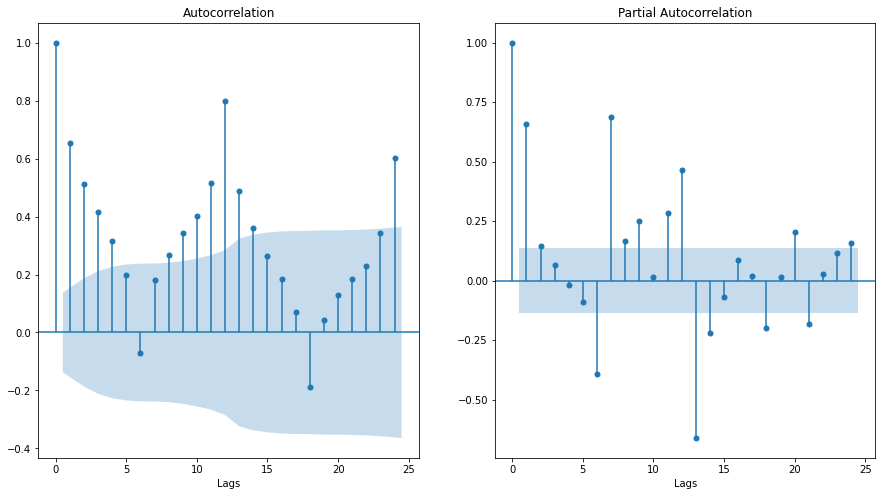

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
res_acf = plot_acf(df_train['passengers'], ax=ax[0])
ax[0].set_xlabel('Lags')
res_pacf = plot_pacf(df_train['passengers'], ax=ax[1])
ax[1].set_xlabel('Lags')
plt.show()

### Making Data Stationary

In [13]:
df_train

,month,passengers
0,2000-01-01,46492
1,2000-02-01,48526
2,2000-03-01,58764
3,2000-04-01,56033
4,2000-05-01,58201
...,...,...
199,2016-08-01,73450
200,2016-09-01,66477
201,2016-10-01,69539
202,2016-11-01,66591


In [14]:
def test_stationarity(ts):
    # Determine stationarity using rolling Stats
    roll_mean = ts.rolling(window=52).mean()
    roll_std = ts.rolling(window=52).std()
    
    plt.plot(ts, color='blue', label='Original ts')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Std')
    plt.show()
    
    # Perform Dickey Fuller Test
    print("\nResults of Dickey Fuller Test: \n")
    df_test = adfuller(ts)
    df_output = pd.Series(df_test[:4], index=['Test Statistics', 'P-value', '#Lags Used', '#Observations'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

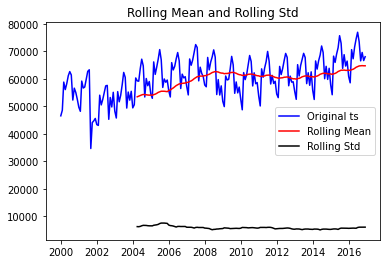


Results of Dickey Fuller Test: 

Test Statistics          -0.952912
P-value                   0.770049
#Lags Used               13.000000
#Observations           190.000000
Critical Value (1%)      -3.465244
Critical Value (5%)      -2.876875
Critical Value (10%)     -2.574945
dtype: float64


In [15]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

test_stationarity(df_train.set_index('month'))

**NOTE:** Time Series is not Stationary.

In [16]:
# df_train_diff = df_train['passengers'] - df_train['passengers'].shift()
# df_train_diff
# or
df_train_diff = df_train['passengers'].diff()
df_train_diff

0          NaN
1       2034.0
2      10238.0
3      -2731.0
4       2168.0
        ...   
199    -3436.0
200    -6973.0
201     3062.0
202    -2948.0
203     1392.0
Name: passengers, Length: 204, dtype: float64

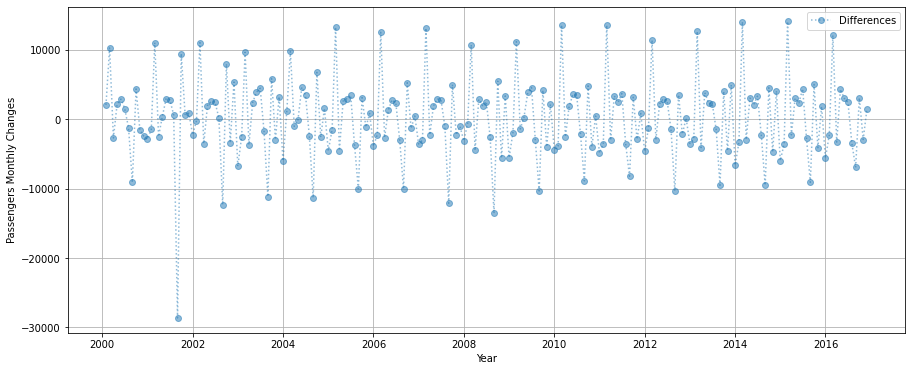

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['month'], df_train_diff, 'o:', alpha=0.5)
plt.legend(['Differences'])
plt.xlabel('Year')
plt.ylabel('Passengers Monthly Changes')
plt.grid()
plt.show()

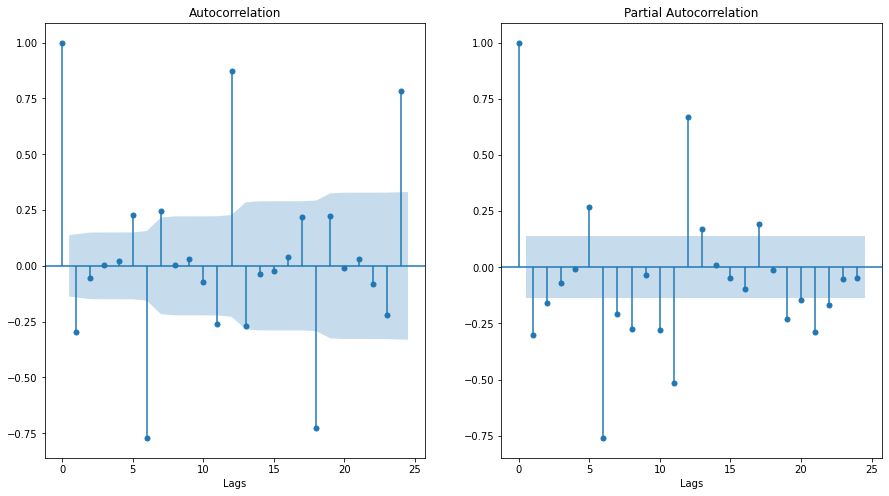

In [18]:
df_train_diff.dropna(inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
res_acf = plot_acf(df_train_diff, ax=ax[0])
ax[0].set_xlabel('Lags')
res_pacf = plot_pacf(df_train_diff, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.show()

### Auto Regressive Model- AR(12)

In [19]:
x_train = df_train.set_index('month')
x_test = df_test.set_index('month')

In [20]:
x_train.head()

,passengers
month,
2000-01-01,46492
2000-02-01,48526
2000-03-01,58764
2000-04-01,56033
2000-05-01,58201


In [21]:
from statsmodels.tsa.ar_model import AutoReg

In [22]:
model_ar = AutoReg(x_train, lags=12).fit()

C:\Users\Anubhav Karelia\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Anubhav Karelia\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [23]:
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:             passengers   No. Observations:                  204
Model:                    AutoReg(12)   Log Likelihood               -1791.208
Method:               Conditional MLE   S.D. of innovations           2725.128
Date:                Wed, 05 May 2021   AIC                             15.966
Time:                        18:47:27   BIC                             16.204
Sample:                    01-01-2001   HQIC                            16.063
                         - 12-01-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1101.8877   2670.461     -0.413      0.680   -6335.894    4132.119
passengers.L1      0.4234      0.062      6.848      0.000       0.302       0.545
passengers.L2      0.0487      0.069

In [24]:
fitted_values = model_ar.fittedvalues

In [25]:
fitted_values.head()

month
2001-01-01    49334.710929
2001-02-01    49964.903006
2001-03-01    57480.606603
2001-04-01    55642.948449
2001-05-01    57963.182409
dtype: float64

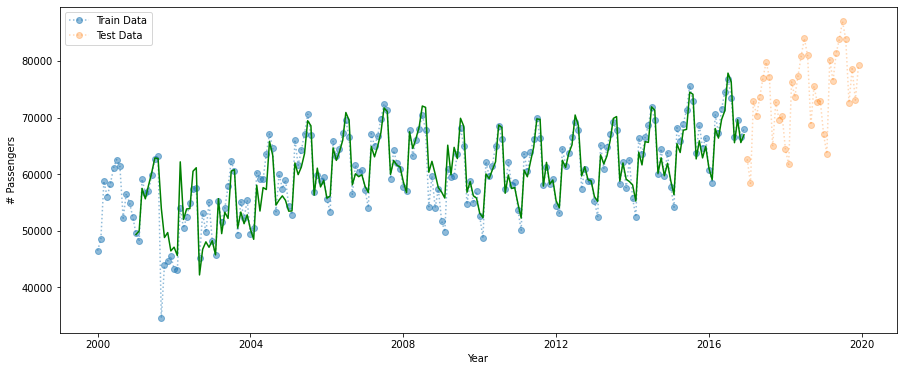

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['month'], df_train['passengers'], 'o:', alpha=0.5)
plt.plot(df_test['month'], df_test['passengers'], 'o:', alpha=0.3)

#fitted values
plt.plot(fitted_values, 'g-')
plt.legend(['Train Data', 'Test Data'])
plt.xlabel('Year')
plt.ylabel('# Passengers')
plt.show()

In [28]:
start = datetime.datetime.strptime('2017-01-01', '%Y-%m-%d')
end = datetime.datetime.strptime('2019-12-01', '%Y-%m-%d')
forecasted_values = model_ar.predict(start, end)

C:\Users\Anubhav Karelia\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [29]:
ME = 1.96*model_ar.resid.std()

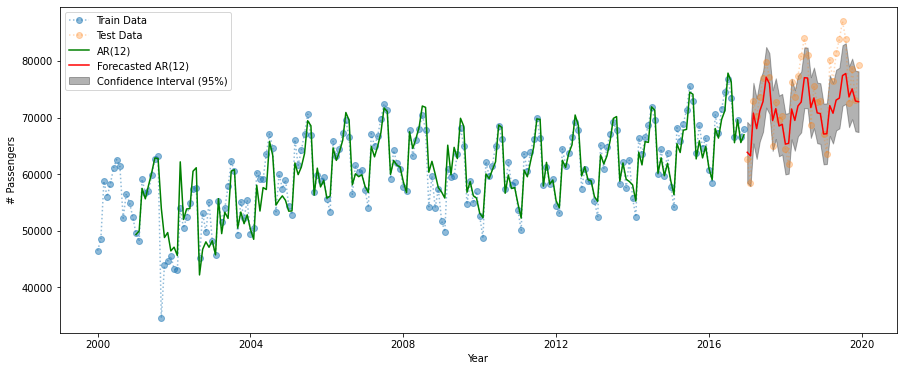

In [35]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['month'], df_train['passengers'], 'o:', alpha=0.5)
plt.plot(df_test['month'], df_test['passengers'], 'o:', alpha=0.3)

#fitted values
plt.plot(fitted_values, 'g-')
# forcasted values
plt.plot(forecasted_values, 'r')

plt.fill_between(df_test['month'], (forecasted_values+ME), (forecasted_values-ME), alpha=0.3, color='black')
plt.legend(['Train Data', 'Test Data', 'AR(12)', 'Forecasted AR(12)', 'Confidence Interval (95%)'])
plt.xlabel('Year')
plt.ylabel('# Passengers')
plt.show()

### Model Evaluation

C:\Users\Anubhav Karelia\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


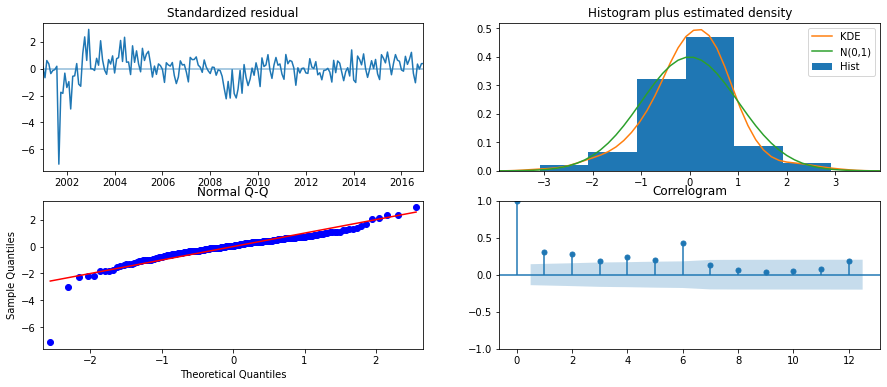

In [40]:
fig = plt.figure(figsize=(15, 6))
fig = model_ar.plot_diagnostics(lags=12, fig=fig);